In [2]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

### Loading and normalizing the CIFAR10 test set (train set later)


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


### Defining the Convolutional Neural Network


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Defining a Loss function (optimizer later)


In [5]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

## Task 1: Testing the effects of randomness
First, we will print the values of the weights of the fully connected layer `fc3` to investige its initial parameters. For visualization purposes, only the first weight tensor will be used, this tensor has 84 weights in size, as the previous layer had 84 output features:

In [6]:
net1 = Net()

print(net1.fc3.weight.data[0])

tensor([-0.0391, -0.0191,  0.0587, -0.0595,  0.0759, -0.1023,  0.0925,  0.0683,
        -0.0621,  0.0042, -0.0383, -0.0753, -0.0637,  0.0747,  0.0125, -0.0448,
        -0.0113,  0.0970,  0.0800, -0.0165, -0.0028,  0.0423,  0.0895,  0.0937,
         0.1040,  0.0718,  0.0090, -0.0832,  0.0288, -0.0426,  0.0525, -0.0953,
         0.0022, -0.1018,  0.0445, -0.0603, -0.0117, -0.0750,  0.0956, -0.0336,
         0.0320, -0.0835,  0.1073,  0.1067,  0.1000, -0.0097,  0.0918,  0.0740,
        -0.0753,  0.1024,  0.0133, -0.0998,  0.0041,  0.0560,  0.0398, -0.0756,
        -0.0940, -0.0779,  0.0066,  0.0458, -0.0145,  0.0582, -0.0529,  0.0072,
         0.1062, -0.0072,  0.0404, -0.0862, -0.0995,  0.1066, -0.0369,  0.0672,
         0.0038,  0.0211,  0.0188,  0.0128,  0.0061,  0.0174, -0.0203,  0.0282,
         0.0614,  0.0410,  0.0581, -0.0022])


Now let's compare these weights to those of a different newly-initialized neural network:

In [7]:
net2 = Net()

print(net2.fc3.weight.data[0])

tensor([ 0.0716,  0.0079, -0.0954,  0.0999, -0.0377,  0.0054,  0.0587,  0.0511,
         0.0296, -0.0135, -0.0528, -0.0847,  0.0017, -0.1061, -0.0349,  0.0457,
        -0.0411,  0.0932, -0.0511, -0.1078,  0.0559,  0.0977,  0.0510,  0.0949,
        -0.0205,  0.0984,  0.0188, -0.0563, -0.0614,  0.1069,  0.0250,  0.0711,
         0.1065,  0.0430,  0.0965, -0.1038,  0.0647,  0.0938, -0.0280,  0.1049,
        -0.0911, -0.0434, -0.0895,  0.0494, -0.0488, -0.0022, -0.0252, -0.0206,
        -0.0976,  0.0937,  0.0322,  0.0621,  0.0955, -0.0220,  0.0108, -0.0094,
         0.0426, -0.0646, -0.0360, -0.0489,  0.0349,  0.0456,  0.0473, -0.0631,
        -0.0481, -0.0772,  0.0440,  0.0381, -0.0332, -0.0146,  0.0476, -0.0416,
        -0.0501,  0.0980,  0.0926,  0.0937, -0.0296,  0.0189,  0.1088,  0.0411,
         0.0912, -0.0891,  0.0046,  0.0431])


The parameters are different due to the stochasticity of the weight initialization process.

Now let's investigate a second source of randomness: the ordering of our dataset. Let's see the first batch (of size 4) of two different datasets.

First batch from trainloader1:


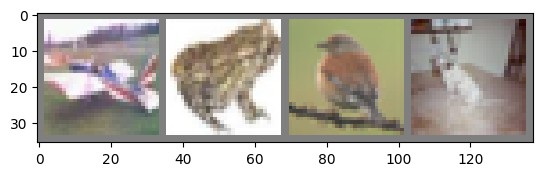

        plane          frog          bird           dog

First batch from trainloader2:


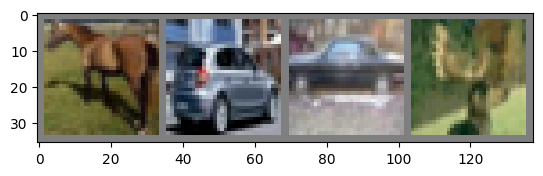

        horse           car           car          deer


In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


def get_first_batch(dataloader):
    images, labels = next(iter(dataloader))
    images, labels = list(images), list(labels)
    return images, labels

trainset1 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader1 = torch.utils.data.DataLoader(trainset1, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

print('First batch from trainloader1:')
images1, labels1 = get_first_batch(trainloader1)
imshow(torchvision.utils.make_grid(images1))
plt.show()
print(' '.join('%13s' % classes[label] for label in labels1))

trainset2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

print('\nFirst batch from trainloader2:')
images2, labels2 = get_first_batch(trainloader2)
imshow(torchvision.utils.make_grid(images2))
plt.show()
print(' '.join('%13s' % classes[label] for label in labels2))

The images are different because the dataset is randomly shuffled when it is loaded.

Now, let's train the two models with these different weight initializations and dataset ordering and compare the results:

In [9]:
optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader1, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer1.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer1.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

for epoch in range(5):

    running_loss = 0.0
    for i, data in enumerate(trainloader2, 0):

        inputs, labels = data

        optimizer2.zero_grad()

        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.262
[1,  4000] loss: 1.862
[1,  6000] loss: 1.696
[1,  8000] loss: 1.580
[1, 10000] loss: 1.533
[1, 12000] loss: 1.470
[2,  2000] loss: 1.406
[2,  4000] loss: 1.371
[2,  6000] loss: 1.361
[2,  8000] loss: 1.317
[2, 10000] loss: 1.314
[2, 12000] loss: 1.282
[3,  2000] loss: 1.230
[3,  4000] loss: 1.221
[3,  6000] loss: 1.200
[3,  8000] loss: 1.219
[3, 10000] loss: 1.183
[3, 12000] loss: 1.203
[4,  2000] loss: 1.128
[4,  4000] loss: 1.123
[4,  6000] loss: 1.144
[4,  8000] loss: 1.113
[4, 10000] loss: 1.113
[4, 12000] loss: 1.112
[5,  2000] loss: 1.043
[5,  4000] loss: 1.034
[5,  6000] loss: 1.048
[5,  8000] loss: 1.048
[5, 10000] loss: 1.072
[5, 12000] loss: 1.065
[1,  2000] loss: 2.188
[1,  4000] loss: 1.872
[1,  6000] loss: 1.665
[1,  8000] loss: 1.586
[1, 10000] loss: 1.513
[1, 12000] loss: 1.490
[2,  2000] loss: 1.414
[2,  4000] loss: 1.403
[2,  6000] loss: 1.365
[2,  8000] loss: 1.344
[2, 10000] loss: 1.327
[2, 12000] loss: 1.296
[3,  2000] loss: 1.259
[3,  4000] 

Now we compare the accuracy of both models trained equally:

In [10]:
def ascore(net1, net2, testloader):
    correct1, correct2 = 0, 0
    acount = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs1 = net1(images)
            outputs2 = net2(images)
            _, predicted1 = torch.max(outputs1, 1)
            _, predicted2 = torch.max(outputs2, 1)
            total += labels.size(0)
            correct1 += (predicted1 == labels).sum().item()
            correct2 += (predicted2 == labels).sum().item()
            acount += (predicted1 == predicted2).sum().item()

    acc1 = 100 * correct1 / total
    acc2 = 100 * correct2 / total
    agreement = 100 * acount / total
    return acc1, acc2, agreement


acc1, acc2, agreement = ascore(net1, net2, testloader)

print(f'Accuracy of net1 on the 10000 test images: {acc1:.2f}%')
print(f'Accuracy of net2 on the 10000 test images: {acc2:.2f}%')
print(f'Percentage of images where both models had the same prediction (agreement score): {agreement:.2f}%')

Accuracy of net1 on the 10000 test images: 58.97%
Accuracy of net2 on the 10000 test images: 59.03%
Percentage of images where both models had the same prediction (agreement score): 57.66%


Both models achieved a similar top-1 accuracy of around 59%, with the prediction agreement score being really close to the individual network accuracies. This indicates that 58% of the time, both models predict the same label for the same test image, and the models' errors are highly correlated. The primary reason the agreement is not 100% is the stochastic nature of neural network training. Specifically, the models started with different randomly initialized weights, which causes them to converge to different solutions (or local minima). Furthermore, both models trained on the same dataset but used different mini-batch shuffling, which alters the gradient descent path taken during training. Both of these independent factors impact which features and decision boundaries each network learns, ultimately causing discrepancies in their predictions on the test set.

## Task 2: Understanding network's confidence in making predictions



We will use `net1` to perform an analysis of the correlation between accuracy and confidence. First, we will use softmax to find the probability distribution of the model's outputs. This distribution is quantified using the entropy formula: $$H(P) = -\sum_{i=1}^{K} p_i \log(p_i)$$

We will compute the average entropy over 100 images from each class to determine how accurate and confident it is for each class.

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
class_entropy = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net1(images)
        probabilities = F.softmax(outputs, dim = 1) # find probabilities from output
        entropy_scores = -torch.sum(probabilities*torch.log(probabilities.clamp(min=1e-9)), dim = 1) # calculate entropy
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]

            if class_total[label] < 100: # we are sampling 100 per class
                class_correct[label] += c[i].item()
                class_total[label] += 1
                class_entropy[label] += entropy_scores[i].item()

print("{:<10} {:<15} {:<15}".format("Class", "Accuracy", "Avg. Entropy"))
for i in range(10):
    class_name = classes[i]
    accuracy = 100 * class_correct[i] / class_total[i]
    avg_entropy = class_entropy[i] / class_total[i]
    print("{:<10} {:<15.2f} {:<15.2f}".format(class_name, accuracy, avg_entropy))

Class      Accuracy        Avg. Entropy   
plane      56.00           0.96           
car        94.00           0.48           
bird       41.00           1.27           
cat        45.00           1.44           
deer       34.00           1.39           
dog        51.00           1.32           
frog       74.00           0.93           
horse      76.00           0.86           
ship       80.00           0.74           
truck      54.00           0.84           


The results show that `net1` is more accurate and confident in some classes than others. The car class had the highest accuracy and lowest average entropy, and the bird class had the lowest accuracy and highest entropy. There is an inversely proportional relationship between accuracy and average entropy, meaning that the more confident the model is on average about a class prediction, the more accurate it is at predicting that class.




## Task 3: Behavior to unseen images

Now, let's see how the network behaves when we input imajes from unseen object categories or from unnatural distributions (e.g., Gaussian noise). We will load the CIFAR100 dataset and pass 100 images from each of the 100 classes, and then analyze what images from these classes get classified as, as well as computing their average entropies. We will also compute this average entropy for 100 randomly sampled Gaussian noise images to test the effects of passing complete random inputs to our model.

In [21]:
testset100 = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader100 = torch.utils.data.DataLoader(testset100, batch_size=4, shuffle=False, num_workers=2)

class_pred = [[0. for j in range(10)] for i in range(100)]

with torch.no_grad():
    for images, labels in testloader100:

        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            true_label = labels[i].item()
            pred_label = predicted[i].item()

            class_pred[true_label][pred_label] += 1

counts = torch.tensor(class_pred)
probabilities = counts / counts.sum(dim = 1, keepdim=True)
entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-9), dim=1)
entropies = list(zip(entropy.tolist(), testset100.classes))
entropies.sort(key=lambda x: x[0])

print("5 classes with highest entropy (least confident):")
for entropy, name in entropies[:-6:-1]:
    print(f"Class: {name} | Entropy: {entropy:.2f}")

print("\n5 classes with lowest entropy (most confident):")
for entropy, name in entropies[:5]:
    print(f"Class: {name} | Entropy: {entropy:.2f}")

print("\nGaussian Noise Analysis:\n")

def print_noise_predictions(noise_counts):
    for i, count in enumerate(noise_counts):
        print(f'{classes[i]}: {int(count)} | ', end='')
    print()

print("Standard Gaussian (Mean=0, Std=1):")
noise = torch.randn(100, 3, 32, 32)

with torch.no_grad():
    outputs = net1(noise)
    _, predicted = torch.max(outputs, 1)

noise_counts = torch.bincount(predicted, minlength=10).float()
noise_probs = noise_counts / noise_counts.sum()
noise_entr = -torch.sum(noise_probs * torch.log(noise_probs + 1e-9)).item()

print(f"Entropy of Gaussian Noise: {noise_entr:.2f}")
print("Noise Prediction Counts:")
print_noise_predictions(noise_counts)

print("\nLow-contrast Gaussian (Mean=0, Std=0.5):")
noise = torch.randn(100, 3, 32, 32) * 0.5

with torch.no_grad():
    outputs = net1(noise)
    _, predicted = torch.max(outputs, 1)

noise_counts = torch.bincount(predicted, minlength=10).float()
noise_probs = noise_counts / noise_counts.sum()
noise_entr = -torch.sum(noise_probs * torch.log(noise_probs + 1e-9)).item()

print(f"Entropy of Gaussian Noise: {noise_entr:.2f}")
print("Noise Prediction Counts:")
print_noise_predictions(noise_counts)

print("\nHigh-contrast Gaussian (Mean=0, Std=2.0):")
noise = torch.randn(100, 3, 32, 32) * 2

with torch.no_grad():
    outputs = net1(noise)
    _, predicted = torch.max(outputs, 1)

noise_counts = torch.bincount(predicted, minlength=10).float()
noise_probs = noise_counts / noise_counts.sum()
noise_entr = -torch.sum(noise_probs * torch.log(noise_probs + 1e-9)).item()

print(f"Entropy of Gaussian Noise: {noise_entr:.2f}")
print("Noise Prediction Counts:")
print_noise_predictions(noise_counts)

print("\nBrighter Gaussian (Mean=1, Std=1.0):")
noise = torch.randn(100, 3, 32, 32) + 1

with torch.no_grad():
    outputs = net1(noise)
    _, predicted = torch.max(outputs, 1)

noise_counts = torch.bincount(predicted, minlength=10).float()
noise_probs = noise_counts / noise_counts.sum()
noise_entr = -torch.sum(noise_probs * torch.log(noise_probs + 1e-9)).item()

print(f"Entropy of Gaussian Noise: {noise_entr:.2f}")
print("Noise Prediction Counts:")
print_noise_predictions(noise_counts)

print("\nDarker Gaussian (Mean=-1, Std=1.0):")
noise = torch.randn(100, 3, 32, 32) - 1

with torch.no_grad():
    outputs = net1(noise)
    _, predicted = torch.max(outputs, 1)

noise_counts = torch.bincount(predicted, minlength=10).float()
noise_probs = noise_counts / noise_counts.sum()
noise_entr = -torch.sum(noise_probs * torch.log(noise_probs + 1e-9)).item()

print(f"Entropy of Gaussian Noise: {noise_entr:.2f}")
print("Noise Prediction Counts:")
print_noise_predictions(noise_counts)

5 classes with highest entropy (least confident):
Class: snake | Entropy: 2.25
Class: keyboard | Entropy: 2.24
Class: dinosaur | Entropy: 2.20
Class: sweet_pepper | Entropy: 2.17
Class: butterfly | Entropy: 2.17

5 classes with lowest entropy (most confident):
Class: pickup_truck | Entropy: 0.86
Class: sea | Entropy: 1.06
Class: bus | Entropy: 1.44
Class: plain | Entropy: 1.46
Class: hamster | Entropy: 1.53

Gaussian Noise Analysis:

Standard Gaussian (Mean=0, Std=1):
Entropy of Gaussian Noise: 0.38
Noise Prediction Counts:
plane: 6 | car: 91 | bird: 0 | cat: 0 | deer: 0 | dog: 0 | frog: 0 | horse: 0 | ship: 2 | truck: 1 | 

Low-contrast Gaussian (Mean=0, Std=0.5):
Entropy of Gaussian Noise: 0.83
Noise Prediction Counts:
plane: 8 | car: 73 | bird: 0 | cat: 0 | deer: 0 | dog: 0 | frog: 0 | horse: 0 | ship: 16 | truck: 3 | 

High-contrast Gaussian (Mean=0, Std=2.0):
Entropy of Gaussian Noise: 0.35
Noise Prediction Counts:
plane: 5 | car: 92 | bird: 0 | cat: 0 | deer: 0 | dog: 0 | frog: 0

### Unseen Classes:
When passing 100 images from each class of CIFAR-100 into our CIFAR-10-trained model `net1`, we can see that the model is less confident in the classes `snake`, `keyboard`, `dinosaur`, `sweet_pepper`, and `butterfly`. A possible explanation for this is that these classes are not very similar to the average shape of any of CIFAR-10's classes. The inverse is true for the most confident classes, where the shape of classes like `pickup_truck` and `bus` are generally similar to those of `car` that is present in CIFAR-10, while the other three like `sea`, `plain`, `and hamster` might have similar background features to classes like `ship` (which usually comes with water, like `sea`) or other classes that generally share similar backgrounds. Overall, this seems to make sense but as we will see in the next analysis, this intuition we have about classes sharing similar high-level features might not translate to what is actually happening inside the model.

### Gaussian Noise:

The experiment with different types of gaussian noise show that texture is a big determining factor in classifying an image as a car. The standard, dark, and low-contrast variants of gaussian had very low entropy, meaning the network was very confident that those images were cars. This shows that the network did not learn what the shape of a car is, but instead learned that a highly textured image corresponds to a car. The brighter gaussian (with a mean value of 1), was able to scatter the predictions slightly, but still with a high bias towards cars. This shows that this model did not learn the features we would expected it to.

### Conclusion:

The model is not robust, and classifies purely noisy images as specific classes with high confidence, instead of relying on the high-level shapes we would expect it to.